# Image Processing SS 18 - Assignment - 09

### Deadline is 20.6.2016 at 8:00 o'clock

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import scipy.io.wavfile
from skimage.data import astronaut
from skimage.color import rgb2gray

from __future__ import division
import random
try:
    from StringIO import StringIO as BytesIO
except ImportError:
    from io import BytesIO
    
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
    
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2
from scipy.fftpack import dct
from PIL import Image
import itertools
import IPython
import zipfile
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - JPEG - 10 Points

The Wikipedia page about [JPEG-Komprimierung](https://de.wikipedia.org/wiki/JPEG#Die_JPEG-Komprimierung) gives
a good overview. The Wikipedia pages also assumes that all images are between 0 and 255. That is why we do not convert it to 0-1 as an exception.

In [3]:
img = astronaut() # The 
img.shape

(512, 512, 3)

In [4]:
class Blocks:
    """Transforms an image to blocks. A (512, 512) image will become an (64, 64, 8, 8) numpy array"""
    def __init__(self, block_size=8):
        self.block_size = block_size
        
    def __call__(self, img):
        b = self.block_size
        heigth, width = img.shape
        assert img.shape[0] % b == 0
        assert img.shape[1] % b == 0
        blocks = np.zeros((heigth // b, width // b, b, b), dtype=img.dtype)
        for i in range(0, heigth // b):
            for j in range(0, heigth // b):
                blocks[i, j] = img[i*b:(i+1)*b, j*b:(j+1)*b]
        return blocks

    def invert(self, blocks):
        bh, bw = blocks.shape[:2]
        b = self.block_size
        heigth, width = (bh*self.block_size, bw*self.block_size)

        img = np.zeros((heigth, width), dtype=blocks.dtype)
        for i in range(0, bh):
            for j in range(0, bw):
                img[i*b:(i+1)*b, j*b:(j+1)*b] = blocks[i, j]
        return img
    

img_blocks = Blocks(block_size=8)(img[:, :, 0])
print(img_blocks.shape)
assert img_blocks.shape[2:] == (8, 8)
img_inv = Blocks(block_size=8).invert(img_blocks)
assert (img[:, :, 0] == img_inv).all()

(64, 64, 8, 8)


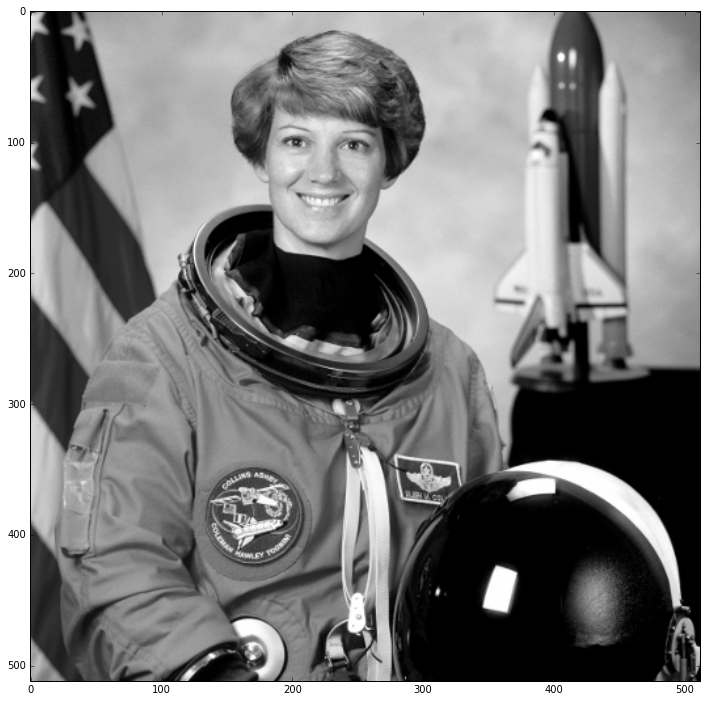

In [5]:
class ChromaSubsampling:
    """See https://en.wikipedia.org/wiki/YCbCr."""
    ycbcr = np.array([
        [0.299,  0.587,  0.114],
        [-0.168736, -0.331264,  0.5],
        [0.5, -0.418688, -0.0813],
    ])
    def __call__(self, rgb_img):
        """Transforms the rgb image to YCbCr. The cb and cr channels have half the resolution of the Y-channel.
           You can simply use the mean of four neighbours.
        """
        shape = rgb_img.shape
        
        ycbcr_img = np.dot(self.ycbcr, rgb_img.reshape(-1, 3).T)
        ycbcr_img = ycbcr_img.T.reshape(shape)
        # subsample the cb and cr channel, so that they have half the resolution of the Y-channel.
        # A simple thing might be to use the mean of 4 neighbours.
        # your code here
        return ycbcr_img[:, :, 0], ycbcr_img[:, :, 1], ycbcr_img[:, :, 2]
    
    def invert(self, inputs):
        y, cb, cr = inputs
        # your code here
        return np.stack([y, y, y], axis=-1)

class DCTofBlocks:
    def __call__(self, blocks):
        """Returns the DCT of the blocks. The position (i, j) is a 2-dim numpy array with the dct coefficents."""
        # you can use any function from np.fft or scipy.fftpack
        # your code here
        return blocks
    
    def invert(self, blocks):
        """Computes the inverse DCT."""
        # you can use any function from np.fft or scipy.fftpack
        # your code here
        return blocks 

class Quantizise:
    def __init__(self, threshold=1):
        # you can use the Q matrix from wikipedia or invent your own.
        self.q_matrix = []
        self.threshold = threshold

    def __call__(self, blocks):
        """Divides the blocks by the `q_matrix` elementwise. Coefficents under the `threshold` will be set to zero."""
        # your code here
        return blocks
    
    def invert(self, blocks):
        """ For inverting multiply your elements piecewise with the Q-Matrix"""
        return blocks

class PickNthHighest():
    def __init__(self, n=1):
        self.n = n

    def __call__(self, blocks):
        """Pick the nth-highest frequencies"""
        # your code here
        return blocks
    
    def invert(self, blocks):
        """There is no way to invert this operation. Just return the inputs."""
        return blocks

plt.imshow(ChromaSubsampling()(astronaut())[0], cmap='gray')

In [6]:
class ZigZack:
    def __init__(self, n):
        self.n = n
        """Adapted from here: https://rosettacode.org/wiki/Zig-zag_matrix#Python"""
        def key(pair):
            x, y = pair
            return (x+y, -y if (x+y) % 2 else y)

        n = 8
        indexorder = sorted(((x,y) for x in range(n) for y in range(n)), key=key)
        self.xs = np.zeros((self.n**2,), dtype=np.int)
        self.ys = np.zeros((self.n**2,), dtype=np.int)
        self.back = np.zeros((n, n), dtype=np.int)
        for i, (x, y) in enumerate(indexorder):
            self.xs[i] = x
            self.ys[i] = y
            self.back[x, y] = i
            
    def __call__(self, blocks):
        bh, bw, h, w = blocks.shape
        zigzack_blocks = np.zeros((bh, bw, h*w), dtype=blocks.dtype)
        for i, block_row in enumerate(blocks):
            for j, block in enumerate(block_row):
                zigzack_blocks[i, j] = block[self.xs, self.ys] 
        return zigzack_blocks
    
    def invert(self, zigzack_blocks):
        bh, bw, hw = zigzack_blocks.shape
        h = int(np.sqrt(hw))
        blocks = np.zeros((bh, bw, h, h), dtype=zigzack_blocks.dtype)
        for i, zigzack_row in enumerate(zigzack_blocks):
            for j, zigzack in enumerate(zigzack_row):
                blocks[i, j] = zigzack[self.back] 
        return blocks

zigzag = ZigZack(8)
range_mat = np.arange(64).reshape(1, 1, 8, 8)
zigzack_mat = zigzag(range_mat)
assert (zigzag.invert(zigzack_mat) == range_mat).all()

In [7]:
class Compress:
    def __init__(self, dtype=np.int8):
        self.dtype = dtype
        self.max_value = (np.iinfo(dtype).max  / 1.1)
        
    def __call__(self, arr):
        # print("dtype: {}".format(arr.dtype))
        # print("max: {}, min: {}".format(arr.max(), arr.min()))
        scale = max(abs(arr.max()), abs(arr.min()))
        arr = arr / scale 
        arr = arr * self.max_value
        arr = np.rint(arr)
        arr = arr.astype(self.dtype)
        bytearr = arr.data.tobytes()
        
        return zipfile.bz2.compress(bytearr), arr.shape, arr.dtype, scale
    
    def invert(self, inputs):
        bytearr, shape, dtype, scale = inputs
        decom_bytes = zipfile.bz2.decompress(bytearr)
        arr = np.frombuffer(decom_bytes, dtype=self.dtype)
        arr = arr.astype(dtype)
        arr = arr / self.max_value * scale
        return arr.reshape(shape)

range_mat = np.arange(64, dtype=np.float64).reshape(1, 1, 8, 8)
compress = Compress()
compressed = compress(range_mat)
# print((compress.invert(compressed)))
assert np.allclose(compress.invert(compressed), range_mat, 0.5, 0.5)

In [8]:
class Jpeg:
    def __init__(self, stages):
        self.stages = stages
    
    def __call__(self, img):
        y, cb, cr = ChromaSubsampling()(img)
        outputs = []
        for input in [y, cb, cr]:
            output = input
            for stage in self.stages:
                input = output
                try:
                    output = stage(input)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        return outputs
    
    def invert(self, inputs):
        outputs = []
        for output in inputs:
            for stage in self.stages[::-1]:
                input = output
                try:
                    output = stage.invert(input)
                except:
                    print("Error in Stage: {}".format(type(stage).__name__))
                    raise
            outputs.append(output)
        y, cb, cr = outputs
        return ChromaSubsampling().invert([y, cb, cr])
    


In [9]:
def total_size_jpeg(jpeg_output):
    """Summs the number of bytes over the different compression channels: y, cb, cr"""
    nb_bytes = sum([len(x[0]) for x in jpeg_output])
    return "{:.1f}KB".format(nb_bytes / 1000)

def total_size_numpy(arr):
    return "{:.1f}KB".format(len(arr.data.tobytes()) / 1000)

def naive_compression_size(arr):
    bytearr = arr.data.tobytes()
    nb_bytes = len(zipfile.bz2.compress(bytearr))
    return "{:.1f}KB".format(nb_bytes / 1000)

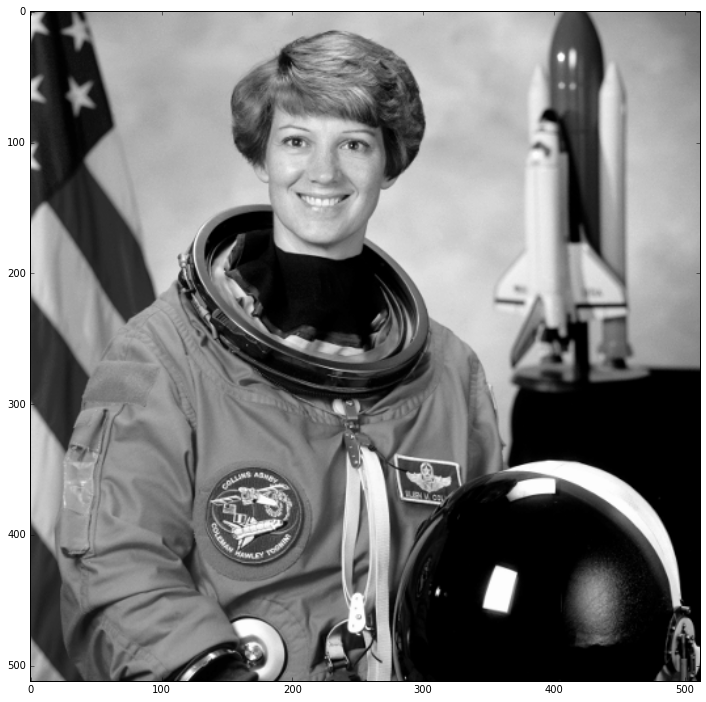

In [10]:
# build the jpeg pipeline
# for testing you can use only the first ones.
# maybe you have to adjust the Quantizise.threshold settings.
jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantizise(threshold=10), ZigZack(8), Compress(np.int8)])

img_jpeg = jpeg(img)
img_reconstruct = jpeg.invert(img_jpeg)
assert img_reconstruct.shape == img.shape
# once you implemted ChormaSubsampling.invert this should have colors :)
plt.imshow(img_reconstruct / 255)
plt.show()

In [11]:
chromasubsampling_compression = Jpeg([Blocks(8), Compress()])
print("No compression: " + total_size_numpy(img))
print("Direct compression of the image: " + naive_compression_size(img))
print("Cromasubsampling and compression: " + total_size_jpeg(chromasubsampling_compression(img)))

No compression: 786.4KB
Direct compression of the image: 499.3KB
Cromasubsampling and compression: 390.6KB


In [12]:
# Compare the size of the images if the zigzack encoding is removed.
# Does the size change if the Quantizise.threshold increases?
jpeg = Jpeg([Blocks(8), DCTofBlocks(), Quantizise(threshold=10), Compress(np.uint8)])

# your code here

In [13]:
# Compare the image quality of the `Quantizise` vs. the `PickNthHighest` compressions. Make sure that the outputs 
# are roughly the same size. Why is one better then the other one?

# your code here

# your short awnser here
